# Campus Security & Visitor Management Analysis
## Comprehensive Data Analysis Pipeline

**Data Source:** Daily Security Reports (Feb 2024 - Sep 2025)  
**Output:** All metrics saved to `result/` folder for Streamlit dashboard

---

### Pipeline Structure:
1. **Data Loading & Initial Parsing**
2. **Data Quality Validation & Cleaning**
3. **Temporal Analysis**
4. **Category Analysis**
5. **Operational Metrics**
6. **Stakeholder Insights**
7. **Advanced Analytics**
8. **Export All Results**

In [1]:
# ========================================
# SECTION 1: IMPORTS & SETUP
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Create result directory if it doesn't exist
os.makedirs('result', exist_ok=True)

print("✅ All libraries imported successfully")
print(f"📁 Result folder ready: {os.path.abspath('result')}")

✅ All libraries imported successfully
📁 Result folder ready: /Users/keshavdubey/Desktop/Keshav's Vault/Academics/DT/Project/DB/result


In [2]:
# ========================================
# SECTION 2: DATA LOADING & INITIAL PARSING
# ========================================

# Load raw CSV
df_raw = pd.read_csv('report.csv', header=None)
print(f"📊 Raw data loaded: {df_raw.shape[0]} rows × {df_raw.shape[1]} columns")

# Parse the messy structure
data = []
current_date = None

for i, row in df_raw.iterrows():
    row_values = row[1:].tolist()  # Skip empty first column
    
    if len(row_values) == 0:
        continue
    
    # Skip header rows
    if row_values[0] is not None and "Daily Security Report" in str(row_values[0]):
        continue
    
    # Detect date lines
    if row_values[0] is not None and '-' in str(row_values[0]) and len(str(row_values[0])) < 15:
        try:
            # Validate it's actually a date
            pd.to_datetime(row_values[0], format='%d-%b-%y', errors='raise')
            current_date = row_values[0]
            continue
        except:
            pass
    
    # Skip "Total" summary rows
    if row_values[0] == 'Total':
        continue
    
    # Extract Department / Count pairs (every 2 columns)
    for j in range(1, len(row_values), 2):
        dept = row_values[j]
        if dept is None or str(dept).strip() == '' or str(dept).strip().lower() == 'total':
            continue
        
        # Get count from next column
        try:
            if j+1 < len(row_values):
                count_val = row_values[j+1]
                count = int(float(count_val)) if count_val is not None else 0
            else:
                count = 0
        except:
            count = 0
        
        # Only add if we have a valid date and non-zero count
        if current_date and count > 0:
            data.append([current_date, str(dept).strip(), count])

# Create initial dataframe
df = pd.DataFrame(data, columns=['Date', 'Category', 'Count'])

print(f"\n✅ Initial parsing complete:")
print(f"   - Records extracted: {len(df)}")
print(f"   - Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"   - Unique categories: {df['Category'].nunique()}")

df.head(20)

📊 Raw data loaded: 5651 rows × 21 columns

✅ Initial parsing complete:
   - Records extracted: 9521
   - Date range: 1-Apr-24 to 9-Sep-25
   - Unique categories: 36

✅ Initial parsing complete:
   - Records extracted: 9521
   - Date range: 1-Apr-24 to 9-Sep-25
   - Unique categories: 36


,Date,Category,Count
0,10-Feb-24,Palash Nivas,52
1,10-Feb-24,Security,63
2,10-Feb-24,Cabs,307
3,10-Feb-24,nan,1594
4,10-Feb-24,Bakul Nivas,21
5,10-Feb-24,Housekeeping,168
6,10-Feb-24,House maids,12
7,10-Feb-24,Kadamba Nivas,10
8,10-Feb-24,Milk & Paper,8
9,10-Feb-24,Civil Vendors,12


In [3]:
# ========================================
# SECTION 3: DATA QUALITY VALIDATION & CLEANING
# ========================================

print("🔍 DATA QUALITY REPORT")
print("="*60)

# 1. Check for numeric categories (parsing errors)
numeric_categories = df[df['Category'].str.isnumeric()]['Category'].unique()
if len(numeric_categories) > 0:
    print(f"\n⚠️  Found {len(numeric_categories)} numeric categories (likely parsing errors):")
    print(f"   {numeric_categories[:10]}")  # Show first 10
    # Remove numeric categories
    df = df[~df['Category'].str.isnumeric()].copy()
    print(f"   → Removed {len(df[df['Category'].str.isnumeric()])} records with numeric categories")

# 2. Standardize category names
df['Category'] = df['Category'].str.strip().str.title()

# 2.1. Remove 'Nan' category (not meaningful for analysis)
nan_count = len(df[df['Category'] == 'Nan'])
if nan_count > 0:
    print(f"\n⚠️  Removing 'Nan' category: {nan_count} records")
    df = df[df['Category'] != 'Nan'].copy()
    print(f"   → Remaining records: {len(df)}")

# 3. Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')
df = df.dropna(subset=['Date'])  # Remove invalid dates

# 4. Remove duplicates
duplicates = df.duplicated(subset=['Date', 'Category'], keep='first').sum()
if duplicates > 0:
    print(f"\n⚠️  Found {duplicates} duplicate records (same date + category)")
    df = df.drop_duplicates(subset=['Date', 'Category'], keep='first')
    print(f"   → Kept first occurrence of each duplicate")

# 5. Check for negative counts
negative_counts = (df['Count'] < 0).sum()
if negative_counts > 0:
    print(f"\n⚠️  Found {negative_counts} records with negative counts")
    df = df[df['Count'] >= 0]

# 6. Add derived time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.strftime('%b')
df['Quarter'] = df['Date'].dt.quarter
df['DayOfWeek'] = df['Date'].dt.day_name()
df['DayOfWeek_Num'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek_Num'].isin([5, 6])
df['Week'] = df['Date'].dt.isocalendar().week
df['Month_Year'] = df['Date'].dt.to_period('M')

# 7. Consolidate similar categories
category_mapping = {
    'Swiggy': 'Food & Courier Delivery',
    'Zomoto': 'Food & Courier Delivery', 
    'Zomato': 'Food & Courier Delivery',
    'Eat Club': 'Food & Courier Delivery',
    'Dominos Pizza': 'Food & Courier Delivery',
    'Food Delivery': 'Food & Courier Delivery',
    'Couriers': 'Food & Courier Delivery',
    'Support Staff': 'Staff',
    'Tcs Staff': 'Staff',
    'Tcs staff': 'Staff',
    'House Maids': 'Housekeeping',
    'House maids': 'Housekeeping',
    'Visitors Bikes': 'Visitors',
    'Event Visitors': 'Event Visitors',
    'Civil Vendors': 'Vendors'
}

df['Category_Original'] = df['Category']
df['Category'] = df['Category'].replace(category_mapping)

# 8. Data completeness check
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
missing_dates = set(date_range) - set(df['Date'].unique())

print(f"\n📊 CLEANED DATA SUMMARY")
print("="*60)
print(f"Total records: {len(df):,}")
print(f"Date range: {df['Date'].min().strftime('%d-%b-%Y')} to {df['Date'].max().strftime('%d-%b-%Y')}")
print(f"Total days: {(df['Date'].max() - df['Date'].min()).days + 1}")
print(f"Days with data: {df['Date'].nunique()}")
print(f"Missing dates: {len(missing_dates)}")
print(f"Unique categories (after consolidation): {df['Category'].nunique()}")
print(f"Total visitor count: {df['Count'].sum():,}")

# Save cleaned data
df.to_csv('result/01_cleaned_data.csv', index=False)
print(f"\n✅ Cleaned data saved to: result/01_cleaned_data.csv")

df.head(20)

🔍 DATA QUALITY REPORT

⚠️  Removing 'Nan' category: 1174 records
   → Remaining records: 8347

📊 CLEANED DATA SUMMARY
Total records: 8,347
Date range: 10-Feb-2024 to 25-Sep-2025
Total days: 594
Days with data: 587
Missing dates: 7
Unique categories (after consolidation): 24
Total visitor count: 391,933

✅ Cleaned data saved to: result/01_cleaned_data.csv


,Date,Category,Count,Year,Month,Month_Name,Quarter,DayOfWeek,DayOfWeek_Num,IsWeekend,Week,Month_Year,Category_Original
0,2024-02-10,Palash Nivas,52,2024,2,Feb,1,Saturday,5,True,6,2024-02,Palash Nivas
1,2024-02-10,Security,63,2024,2,Feb,1,Saturday,5,True,6,2024-02,Security
2,2024-02-10,Cabs,307,2024,2,Feb,1,Saturday,5,True,6,2024-02,Cabs
4,2024-02-10,Bakul Nivas,21,2024,2,Feb,1,Saturday,5,True,6,2024-02,Bakul Nivas
5,2024-02-10,Housekeeping,168,2024,2,Feb,1,Saturday,5,True,6,2024-02,Housekeeping
6,2024-02-10,Housekeeping,12,2024,2,Feb,1,Saturday,5,True,6,2024-02,House Maids
7,2024-02-10,Kadamba Nivas,10,2024,2,Feb,1,Saturday,5,True,6,2024-02,Kadamba Nivas
8,2024-02-10,Milk & Paper,8,2024,2,Feb,1,Saturday,5,True,6,2024-02,Milk & Paper
9,2024-02-10,Vendors,12,2024,2,Feb,1,Saturday,5,True,6,2024-02,Civil Vendors
10,2024-02-10,Parijat Nivas,13,2024,2,Feb,1,Saturday,5,True,6,2024-02,Parijat Nivas


In [4]:
# ========================================
# SECTION 4: TEMPORAL ANALYSIS
# ========================================

print("📅 TEMPORAL ANALYSIS")
print("="*60)

# 4.1 Daily footfall
daily_footfall = df.groupby('Date').agg({
    'Count': 'sum',
    'Category': 'nunique'
}).reset_index()
daily_footfall.columns = ['Date', 'Total_Visitors', 'Unique_Categories']
daily_footfall['Year'] = daily_footfall['Date'].dt.year
daily_footfall['Month'] = daily_footfall['Date'].dt.month
daily_footfall['DayOfWeek'] = daily_footfall['Date'].dt.day_name()
daily_footfall['IsWeekend'] = daily_footfall['Date'].dt.dayofweek.isin([5, 6])

# 4.2 Weekly aggregation
weekly_footfall = df.groupby([df['Date'].dt.to_period('W'), 'Category'])['Count'].sum().reset_index()
weekly_footfall.columns = ['Week', 'Category', 'Count']
weekly_footfall['Week'] = weekly_footfall['Week'].astype(str)

# 4.3 Monthly aggregation
monthly_footfall = df.groupby(['Month_Year', 'Category'])['Count'].sum().reset_index()
monthly_footfall['Month_Year_Str'] = monthly_footfall['Month_Year'].astype(str)

# 4.4 Day of week patterns
dow_analysis = df.groupby(['DayOfWeek', 'DayOfWeek_Num']).agg({
    'Count': ['sum', 'mean', 'std', 'count']
}).reset_index()
dow_analysis.columns = ['DayOfWeek', 'DayOfWeek_Num', 'Total_Visitors', 'Avg_Daily', 'StdDev', 'Days_Count']
dow_analysis = dow_analysis.sort_values('DayOfWeek_Num')

# 4.5 Weekend vs Weekday
weekend_comparison = df.groupby('IsWeekend').agg({
    'Count': ['sum', 'mean', 'count']
}).reset_index()
weekend_comparison.columns = ['IsWeekend', 'Total_Visitors', 'Avg_Per_Day', 'Total_Days']
weekend_comparison['IsWeekend'] = weekend_comparison['IsWeekend'].map({True: 'Weekend', False: 'Weekday'})

# 4.6 Monthly trends (total footfall per month)
monthly_totals = df.groupby('Month_Year').agg({
    'Count': 'sum',
    'Date': 'first'
}).reset_index()
monthly_totals.columns = ['Month_Year', 'Total_Visitors', 'First_Date']
monthly_totals['Month_Year_Str'] = monthly_totals['Month_Year'].astype(str)
monthly_totals['YearMonth'] = monthly_totals['First_Date'].dt.strftime('%Y-%m')

# Calculate MoM growth
monthly_totals['MoM_Growth'] = monthly_totals['Total_Visitors'].pct_change() * 100
monthly_totals['MoM_Growth_Absolute'] = monthly_totals['Total_Visitors'].diff()

# 4.7 Quarterly trends
quarterly_footfall = df.groupby(['Year', 'Quarter']).agg({
    'Count': 'sum',
    'Date': ['min', 'max']
}).reset_index()
quarterly_footfall.columns = ['Year', 'Quarter', 'Total_Visitors', 'Start_Date', 'End_Date']
quarterly_footfall['Quarter_Label'] = 'Q' + quarterly_footfall['Quarter'].astype(str) + ' ' + quarterly_footfall['Year'].astype(str)

# 4.8 Year-over-Year comparison
yearly_comparison = df.groupby('Year').agg({
    'Count': 'sum',
    'Date': 'nunique'
}).reset_index()
yearly_comparison.columns = ['Year', 'Total_Visitors', 'Days_With_Data']
yearly_comparison['Avg_Daily_Visitors'] = yearly_comparison['Total_Visitors'] / yearly_comparison['Days_With_Data']

# Save temporal analysis
daily_footfall.to_csv('result/02_daily_footfall.csv', index=False)
weekly_footfall.to_csv('result/03_weekly_footfall.csv', index=False)
monthly_footfall.to_csv('result/04_monthly_category_footfall.csv', index=False)
monthly_totals.to_csv('result/05_monthly_totals.csv', index=False)
dow_analysis.to_csv('result/06_day_of_week_analysis.csv', index=False)
weekend_comparison.to_csv('result/07_weekend_vs_weekday.csv', index=False)
quarterly_footfall.to_csv('result/08_quarterly_footfall.csv', index=False)
yearly_comparison.to_csv('result/09_yearly_comparison.csv', index=False)

print("\n📊 Temporal Metrics Computed:")
print(f"   ✓ Daily footfall: {len(daily_footfall)} days")
print(f"   ✓ Weekly footfall: {len(weekly_footfall)} records")
print(f"   ✓ Monthly footfall: {len(monthly_footfall)} records")
print(f"   ✓ Day of week patterns: 7 days analyzed")
print(f"   ✓ Quarterly trends: {len(quarterly_footfall)} quarters")
print(f"   ✓ Year-over-year: {len(yearly_comparison)} years")

print("\n🎯 KEY INSIGHTS:")
print(f"   - Busiest day: {dow_analysis.iloc[dow_analysis['Total_Visitors'].idxmax()]['DayOfWeek']} ({dow_analysis['Total_Visitors'].max():,} visitors)")
print(f"   - Quietest day: {dow_analysis.iloc[dow_analysis['Total_Visitors'].idxmin()]['DayOfWeek']} ({dow_analysis['Total_Visitors'].min():,} visitors)")
print(f"   - Avg weekday: {weekend_comparison[weekend_comparison['IsWeekend']=='Weekday']['Avg_Per_Day'].values[0]:.0f} visitors/day")
print(f"   - Avg weekend: {weekend_comparison[weekend_comparison['IsWeekend']=='Weekend']['Avg_Per_Day'].values[0]:.0f} visitors/day")

monthly_totals.head(10)

📅 TEMPORAL ANALYSIS

📊 Temporal Metrics Computed:
   ✓ Daily footfall: 587 days
   ✓ Weekly footfall: 1135 records
   ✓ Monthly footfall: 280 records
   ✓ Day of week patterns: 7 days analyzed
   ✓ Quarterly trends: 7 quarters
   ✓ Year-over-year: 2 years

🎯 KEY INSIGHTS:
   - Busiest day: Wednesday (61,703 visitors)
   - Quietest day: Thursday (42,390 visitors)
   - Avg weekday: 48 visitors/day
   - Avg weekend: 44 visitors/day


,Month_Year,Total_Visitors,First_Date,Month_Year_Str,YearMonth,MoM_Growth,MoM_Growth_Absolute
0,2024-02,10901,2024-02-10,2024-02,2024-02,NaN,NaN
1,2024-03,20814,2024-03-01,2024-03,2024-03,90.936611,9913.0
2,2024-04,19119,2024-04-01,2024-04,2024-04,-8.143557,-1695.0
3,2024-05,18850,2024-05-01,2024-05,2024-05,-1.406977,-269.0
4,2024-06,22121,2024-06-01,2024-06,2024-06,17.352785,3271.0
5,2024-07,20062,2024-07-01,2024-07,2024-07,-9.307897,-2059.0
6,2024-08,19850,2024-08-01,2024-08,2024-08,-1.056724,-212.0
7,2024-09,19182,2024-09-01,2024-09,2024-09,-3.365239,-668.0
8,2024-10,19457,2024-10-01,2024-10,2024-10,1.433636,275.0
9,2024-11,20806,2024-11-01,2024-11,2024-11,6.933237,1349.0


In [5]:
# ========================================
# SECTION 5: CATEGORY-WISE ANALYSIS
# ========================================

print("📂 CATEGORY-WISE ANALYSIS")
print("="*60)

# 5.1 Top categories by total count
category_totals = df.groupby('Category').agg({
    'Count': ['sum', 'mean', 'std', 'min', 'max'],
    'Date': 'nunique'
}).reset_index()
category_totals.columns = ['Category', 'Total_Count', 'Avg_Daily', 'StdDev', 'Min_Daily', 'Max_Daily', 'Days_Active']
category_totals = category_totals.sort_values('Total_Count', ascending=False)

# Calculate percentage distribution
category_totals['Percentage'] = (category_totals['Total_Count'] / category_totals['Total_Count'].sum()) * 100

# 5.2 Category stability (coefficient of variation)
category_totals['Coefficient_of_Variation'] = (category_totals['StdDev'] / category_totals['Avg_Daily']) * 100
category_totals['Stability'] = category_totals['Coefficient_of_Variation'].apply(
    lambda x: 'High' if x < 30 else ('Medium' if x < 60 else 'Low')
)

# 5.3 Category growth trends (compare first vs last 3 months)
first_3_months = df[df['Month_Year'] <= df['Month_Year'].min() + 2]
last_3_months = df[df['Month_Year'] >= df['Month_Year'].max() - 2]

first_3_avg = first_3_months.groupby('Category')['Count'].sum()
last_3_avg = last_3_months.groupby('Category')['Count'].sum()

# Merge to handle categories that don't appear in both periods
growth_comparison = pd.DataFrame({
    'First_3_Months_Total': first_3_avg,
    'Last_3_Months_Total': last_3_avg
}).fillna(0).reset_index()
growth_comparison.columns = ['Category', 'First_3_Months_Total', 'Last_3_Months_Total']

growth_comparison['Growth_Absolute'] = growth_comparison['Last_3_Months_Total'] - growth_comparison['First_3_Months_Total']
growth_comparison['Growth_Percentage'] = growth_comparison.apply(
    lambda x: ((x['Last_3_Months_Total'] - x['First_3_Months_Total']) / x['First_3_Months_Total'] * 100) if x['First_3_Months_Total'] > 0 else 0,
    axis=1
)

# 5.4 Category frequency (how often they appear)
category_frequency = df.groupby('Category').agg({
    'Date': 'nunique',
    'Count': 'count'
}).reset_index()
category_frequency.columns = ['Category', 'Unique_Days', 'Total_Records']
total_days = df['Date'].nunique()
category_frequency['Frequency_Percentage'] = (category_frequency['Unique_Days'] / total_days) * 100
category_frequency['Regularity'] = category_frequency['Frequency_Percentage'].apply(
    lambda x: 'Daily' if x > 90 else ('Frequent' if x > 50 else ('Occasional' if x > 20 else 'Rare'))
)

# 5.5 Category peaks (highest single-day counts)
category_peaks = df.groupby('Category').apply(
    lambda x: x.nlargest(1, 'Count')[['Date', 'Count']]
).reset_index(drop=True)
category_peaks = category_peaks.rename(columns={'Date': 'Peak_Date', 'Count': 'Peak_Count'})

# 5.6 Category seasonal patterns
category_seasonal = df.groupby(['Category', 'Month_Name', 'Month']).agg({
    'Count': 'mean'
}).reset_index()
category_seasonal.columns = ['Category', 'Month_Name', 'Month', 'Avg_Count']
category_seasonal = category_seasonal.sort_values(['Category', 'Month'])

# 5.7 Top 20 categories detailed
top_20_categories = category_totals.head(20).copy()

# Save category analysis
category_totals.to_csv('result/10_category_totals.csv', index=False)
growth_comparison.to_csv('result/11_category_growth.csv', index=False)
category_frequency.to_csv('result/12_category_frequency.csv', index=False)
category_peaks.to_csv('result/13_category_peaks.csv', index=False)
category_seasonal.to_csv('result/14_category_seasonal.csv', index=False)
top_20_categories.to_csv('result/15_top_20_categories.csv', index=False)

print("\n📊 Category Metrics Computed:")
print(f"   ✓ Total unique categories: {len(category_totals)}")
print(f"   ✓ Category totals and statistics")
print(f"   ✓ Growth trends (first vs last 3 months)")
print(f"   ✓ Frequency and regularity analysis")
print(f"   ✓ Peak detection for each category")
print(f"   ✓ Seasonal patterns by month")

print(f"\n🎯 TOP 5 CATEGORIES:")
for idx, row in category_totals.head(5).iterrows():
    print(f"   {row['Category']}: {row['Total_Count']:,} visitors ({row['Percentage']:.1f}%)")

print(f"\n📈 FASTEST GROWING CATEGORIES (Last 3 months):")
top_growth = growth_comparison.nlargest(5, 'Growth_Percentage')
for idx, row in top_growth.iterrows():
    print(f"   {row['Category']}: +{row['Growth_Percentage']:.1f}%")

category_totals.head(15)

📂 CATEGORY-WISE ANALYSIS

📊 Category Metrics Computed:
   ✓ Total unique categories: 24
   ✓ Category totals and statistics
   ✓ Growth trends (first vs last 3 months)
   ✓ Frequency and regularity analysis
   ✓ Peak detection for each category
   ✓ Seasonal patterns by month

🎯 TOP 5 CATEGORIES:
   Cabs: 105,737 visitors (27.0%)
   Housekeeping: 73,418 visitors (18.7%)
   Food & Courier Delivery: 45,737 visitors (11.7%)
   Vendors: 35,097 visitors (9.0%)
   Security: 27,074 visitors (6.9%)

📈 FASTEST GROWING CATEGORIES (Last 3 months):
   Vendors: +900.9%
   Mess Workers: +39.6%
   Milk & Paper: +23.4%
   Faculty: +18.0%
   Visitors: +17.0%

📊 Category Metrics Computed:
   ✓ Total unique categories: 24
   ✓ Category totals and statistics
   ✓ Growth trends (first vs last 3 months)
   ✓ Frequency and regularity analysis
   ✓ Peak detection for each category
   ✓ Seasonal patterns by month

🎯 TOP 5 CATEGORIES:
   Cabs: 105,737 visitors (27.0%)
   Housekeeping: 73,418 visitors (18.7%)
  

,Category,Total_Count,Avg_Daily,StdDev,Min_Daily,Max_Daily,Days_Active,Percentage,Coefficient_of_Variation,Stability
4,Cabs,105737,250.561611,78.439076,26,625,422,26.978336,31.305305,Medium
10,Housekeeping,73418,73.125498,74.006037,1,189,586,18.732283,101.204148,Low
7,Food & Courier Delivery,45737,55.776829,60.233167,2,373,165,11.669597,107.989586,Low
20,Vendors,35097,46.858478,25.120538,1,137,587,8.954847,53.609377,Medium
18,Security,27074,64.156398,0.976782,63,65,422,6.907813,1.522502,High
5,Event Visitors,20419,111.579235,126.537980,5,875,183,5.209819,113.406388,Low
19,Staff,19866,48.335766,26.800422,1,91,165,5.068723,55.446357,Medium
14,Mess Workers,16733,28.554608,8.976203,1,66,586,4.269352,31.435219,Medium
21,Visitors,13843,29.266385,29.211837,1,275,473,3.531981,99.813617,Low
16,Palash Nivas,7293,13.000000,11.891924,1,81,561,1.860777,91.476339,Low


In [6]:
# ========================================
# SECTION 6: OPERATIONAL METRICS
# ========================================

print("⚙️ OPERATIONAL METRICS")
print("="*60)

# 6.1 Daily operational summary
daily_operations = daily_footfall.copy()
daily_operations['Is_High_Traffic'] = daily_operations['Total_Visitors'] > daily_operations['Total_Visitors'].quantile(0.75)
daily_operations['Is_Low_Traffic'] = daily_operations['Total_Visitors'] < daily_operations['Total_Visitors'].quantile(0.25)
daily_operations['Traffic_Level'] = daily_operations['Total_Visitors'].apply(
    lambda x: 'Very High' if x > daily_footfall['Total_Visitors'].quantile(0.90) else
              ('High' if x > daily_footfall['Total_Visitors'].quantile(0.75) else
              ('Medium' if x > daily_footfall['Total_Visitors'].quantile(0.50) else
              ('Low' if x > daily_footfall['Total_Visitors'].quantile(0.25) else 'Very Low')))
)

# 6.2 Peak days identification
peak_days = daily_footfall.nlargest(10, 'Total_Visitors')[['Date', 'Total_Visitors', 'DayOfWeek']]
peak_days['Rank'] = range(1, len(peak_days) + 1)

# 6.3 Lowest traffic days
low_traffic_days = daily_footfall.nsmallest(10, 'Total_Visitors')[['Date', 'Total_Visitors', 'DayOfWeek']]
low_traffic_days['Rank'] = range(1, len(low_traffic_days) + 1)

# 6.4 Average visitors by different time periods
operational_stats = pd.DataFrame({
    'Metric': ['Overall Avg Daily', 'Weekday Avg', 'Weekend Avg', 'Q1 Avg', 'Q2 Avg', 'Q3 Avg', 'Q4 Avg'],
    'Value': [
        daily_footfall['Total_Visitors'].mean(),
        daily_footfall[~daily_footfall['IsWeekend']]['Total_Visitors'].mean(),
        daily_footfall[daily_footfall['IsWeekend']]['Total_Visitors'].mean(),
        daily_footfall[daily_footfall['Month'].isin([1,2,3])]['Total_Visitors'].mean(),
        daily_footfall[daily_footfall['Month'].isin([4,5,6])]['Total_Visitors'].mean(),
        daily_footfall[daily_footfall['Month'].isin([7,8,9])]['Total_Visitors'].mean(),
        daily_footfall[daily_footfall['Month'].isin([10,11,12])]['Total_Visitors'].mean(),
    ]
})
operational_stats['Value'] = operational_stats['Value'].round(0)

# 6.5 Capacity and workload indicators
# Assuming security staff ratio (1 security person per 100 visitors)
daily_operations['Estimated_Security_Needed'] = (daily_operations['Total_Visitors'] / 100).apply(np.ceil)

# 6.6 Volatility analysis
daily_operations['MA_7day'] = daily_operations['Total_Visitors'].rolling(window=7, min_periods=1).mean()
daily_operations['MA_30day'] = daily_operations['Total_Visitors'].rolling(window=30, min_periods=1).mean()
daily_operations['Volatility_7day'] = daily_operations['Total_Visitors'].rolling(window=7, min_periods=1).std()

# 6.7 Traffic distribution
traffic_distribution = daily_operations['Traffic_Level'].value_counts().reset_index()
traffic_distribution.columns = ['Traffic_Level', 'Days_Count']
traffic_distribution['Percentage'] = (traffic_distribution['Days_Count'] / len(daily_operations)) * 100

# 6.8 Monthly operational summary
monthly_operations = df.groupby('Month_Year').agg({
    'Count': ['sum', 'mean', 'std'],
    'Date': 'nunique',
    'Category': 'nunique'
}).reset_index()
monthly_operations.columns = ['Month_Year', 'Total_Visitors', 'Avg_Daily', 'StdDev', 'Days_With_Data', 'Unique_Categories']
monthly_operations['Month_Year_Str'] = monthly_operations['Month_Year'].astype(str)

# Save operational metrics
daily_operations.to_csv('result/16_daily_operations.csv', index=False)
peak_days.to_csv('result/17_peak_days.csv', index=False)
low_traffic_days.to_csv('result/18_low_traffic_days.csv', index=False)
operational_stats.to_csv('result/19_operational_stats.csv', index=False)
traffic_distribution.to_csv('result/20_traffic_distribution.csv', index=False)
monthly_operations.to_csv('result/21_monthly_operations.csv', index=False)

print("\n📊 Operational Metrics Computed:")
print(f"   ✓ Daily operational summaries: {len(daily_operations)} days")
print(f"   ✓ Peak days identified: Top 10")
print(f"   ✓ Low traffic days: Bottom 10")
print(f"   ✓ Traffic level classification")
print(f"   ✓ Workload estimation (security staffing)")
print(f"   ✓ Volatility and moving averages")

print(f"\n🎯 KEY OPERATIONAL INSIGHTS:")
print(f"   - Highest traffic day: {peak_days.iloc[0]['Date'].strftime('%d-%b-%Y')} ({peak_days.iloc[0]['Total_Visitors']:,} visitors)")
print(f"   - Lowest traffic day: {low_traffic_days.iloc[0]['Date'].strftime('%d-%b-%Y')} ({low_traffic_days.iloc[0]['Total_Visitors']:,} visitors)")
print(f"   - Overall average: {daily_operations['Total_Visitors'].mean():.0f} visitors/day")
print(f"   - Standard deviation: {daily_operations['Total_Visitors'].std():.0f}")
print(f"   - Peak staffing needed: {daily_operations['Estimated_Security_Needed'].max():.0f} security personnel")

operational_stats

⚙️ OPERATIONAL METRICS

📊 Operational Metrics Computed:
   ✓ Daily operational summaries: 587 days
   ✓ Peak days identified: Top 10
   ✓ Low traffic days: Bottom 10
   ✓ Traffic level classification
   ✓ Workload estimation (security staffing)
   ✓ Volatility and moving averages

🎯 KEY OPERATIONAL INSIGHTS:
   - Highest traffic day: 17-Mar-2024 (1,207 visitors)
   - Lowest traffic day: 11-Apr-2024 (267 visitors)
   - Overall average: 668 visitors/day
   - Standard deviation: 152
   - Peak staffing needed: 13 security personnel

📊 Operational Metrics Computed:
   ✓ Daily operational summaries: 587 days
   ✓ Peak days identified: Top 10
   ✓ Low traffic days: Bottom 10
   ✓ Traffic level classification
   ✓ Workload estimation (security staffing)
   ✓ Volatility and moving averages

🎯 KEY OPERATIONAL INSIGHTS:
   - Highest traffic day: 17-Mar-2024 (1,207 visitors)
   - Lowest traffic day: 11-Apr-2024 (267 visitors)
   - Overall average: 668 visitors/day
   - Standard deviation: 152
   -

,Metric,Value
0,Overall Avg Daily,668.0
1,Weekday Avg,685.0
2,Weekend Avg,623.0
3,Q1 Avg,693.0
4,Q2 Avg,647.0
5,Q3 Avg,668.0
6,Q4 Avg,671.0


In [7]:
# ========================================
# SECTION 7: STAKEHOLDER-SPECIFIC INSIGHTS
# ========================================

print("👥 STAKEHOLDER-SPECIFIC INSIGHTS")
print("="*60)

# 7.1 CAMPUS ADMINISTRATION INSIGHTS

# Food delivery concentration (safety concern)
food_delivery = df[df['Category'] == 'Food & Courier Delivery'].groupby('Date')['Count'].sum().reset_index()
food_delivery['Is_High_Food_Traffic'] = food_delivery['Count'] > food_delivery['Count'].quantile(0.75)

food_summary = {
    'Total_Food_Deliveries': food_delivery['Count'].sum(),
    'Avg_Daily': food_delivery['Count'].mean(),
    'Peak_Day': food_delivery.nlargest(1, 'Count')['Date'].values[0],
    'Peak_Count': food_delivery.nlargest(1, 'Count')['Count'].values[0],
    'High_Traffic_Days': food_delivery['Is_High_Food_Traffic'].sum()
}

# Vendor analysis
vendors = df[df['Category'] == 'Vendors'].groupby('Date')['Count'].sum().reset_index()
vendor_summary = {
    'Total_Vendor_Visits': vendors['Count'].sum(),
    'Avg_Daily': vendors['Count'].mean(),
    'Peak_Day': vendors.nlargest(1, 'Count')['Date'].values[0] if len(vendors) > 0 else None,
    'Peak_Count': vendors.nlargest(1, 'Count')['Count'].values[0] if len(vendors) > 0 else 0
}

# 7.2 SECURITY TEAM INSIGHTS

# Security staff analysis
security = df[df['Category'] == 'Security'].groupby('Date')['Count'].sum().reset_index()
security_summary = {
    'Total_Security_Records': security['Count'].sum(),
    'Avg_Daily': security['Count'].mean(),
    'Days_Active': len(security)
}

# Cab traffic (entry/exit monitoring)
cabs = df[df['Category'] == 'Cabs'].groupby('Date')['Count'].sum().reset_index()
cab_summary = {
    'Total_Cab_Entries': cabs['Count'].sum(),
    'Avg_Daily': cabs['Count'].mean(),
    'Peak_Day': cabs.nlargest(1, 'Count')['Date'].values[0] if len(cabs) > 0 else None,
    'Peak_Count': cabs.nlargest(1, 'Count')['Count'].values[0] if len(cabs) > 0 else 0
}

# Visitor traffic
visitors = df[df['Category'].isin(['Visitors', 'Event Visitors'])].groupby(['Date', 'Category'])['Count'].sum().reset_index()
visitor_summary = visitors.groupby('Category').agg({
    'Count': ['sum', 'mean', 'max']
}).reset_index()
visitor_summary.columns = ['Category', 'Total', 'Avg_Daily', 'Peak']

# 7.3 HOUSING/FACILITIES INSIGHTS

# Nivas (residence halls) traffic
nivas_categories = df[df['Category'].str.contains('Nivas', case=False, na=False)]
nivas_summary = nivas_categories.groupby('Category').agg({
    'Count': ['sum', 'mean'],
    'Date': 'nunique'
}).reset_index()
nivas_summary.columns = ['Nivas', 'Total_Traffic', 'Avg_Daily', 'Days_Active']

# Housekeeping workload
housekeeping = df[df['Category'] == 'Housekeeping'].groupby('Date')['Count'].sum().reset_index()
housekeeping_summary = {
    'Total_Housekeeping_Staff': housekeeping['Count'].sum(),
    'Avg_Daily': housekeeping['Count'].mean(),
    'Peak_Day': housekeeping.nlargest(1, 'Count')['Date'].values[0] if len(housekeeping) > 0 else None,
    'Peak_Count': housekeeping.nlargest(1, 'Count')['Count'].values[0] if len(housekeeping) > 0 else 0
}

# Staff categories
staff_categories = df[df['Category'].isin(['Staff', 'Support Staff'])].groupby(['Date', 'Category'])['Count'].sum().reset_index()
staff_summary = staff_categories.groupby('Category').agg({
    'Count': ['sum', 'mean', 'max']
}).reset_index()
staff_summary.columns = ['Category', 'Total', 'Avg_Daily', 'Peak']

# 7.4 Event analysis
events = df[df['Category'] == 'Event Visitors'].groupby('Date')['Count'].sum().reset_index()
events['Is_Major_Event'] = events['Count'] > events['Count'].quantile(0.90)
major_events = events[events['Is_Major_Event']].sort_values('Count', ascending=False)

# Create stakeholder reports
food_delivery_report = pd.DataFrame([food_summary])
vendor_report = pd.DataFrame([vendor_summary])
security_report = pd.DataFrame([security_summary])
cab_report = pd.DataFrame([cab_summary])
housekeeping_report = pd.DataFrame([housekeeping_summary])

# Save stakeholder insights
food_delivery.to_csv('result/22_food_delivery_daily.csv', index=False)
food_delivery_report.to_csv('result/23_food_delivery_summary.csv', index=False)
vendor_report.to_csv('result/24_vendor_summary.csv', index=False)
security_report.to_csv('result/25_security_summary.csv', index=False)
cab_report.to_csv('result/26_cab_summary.csv', index=False)
visitor_summary.to_csv('result/27_visitor_summary.csv', index=False)
nivas_summary.to_csv('result/28_nivas_summary.csv', index=False)
housekeeping_report.to_csv('result/29_housekeeping_summary.csv', index=False)
staff_summary.to_csv('result/30_staff_summary.csv', index=False)
major_events.to_csv('result/31_major_events.csv', index=False)

print("\n📊 Stakeholder Insights Generated:")
print(f"   ✓ Food delivery analysis (safety monitoring)")
print(f"   ✓ Vendor visit patterns")
print(f"   ✓ Security staff tracking")
print(f"   ✓ Cab/vehicle entry analysis")
print(f"   ✓ Visitor patterns (regular & events)")
print(f"   ✓ Nivas (residence hall) traffic")
print(f"   ✓ Housekeeping workload")
print(f"   ✓ Staff attendance patterns")
print(f"   ✓ Major event identification")

print(f"\n🎯 KEY STAKEHOLDER INSIGHTS:")
print(f"\n📦 Food & Courier Delivery:")
print(f"   - Total deliveries: {food_summary['Total_Food_Deliveries']:,}")
print(f"   - Avg per day: {food_summary['Avg_Daily']:.0f}")
print(f"   - Peak: {food_summary['Peak_Count']:,} on {pd.to_datetime(food_summary['Peak_Day']).strftime('%d-%b-%Y')}")

print(f"\n🚗 Cabs:")
print(f"   - Total entries: {cab_summary['Total_Cab_Entries']:,}")
print(f"   - Avg per day: {cab_summary['Avg_Daily']:.0f}")

print(f"\n🏠 Housekeeping:")
print(f"   - Avg daily staff: {housekeeping_summary['Avg_Daily']:.0f}")

print(f"\n🎉 Major Events Detected: {len(major_events)}")

nivas_summary

👥 STAKEHOLDER-SPECIFIC INSIGHTS

📊 Stakeholder Insights Generated:
   ✓ Food delivery analysis (safety monitoring)
   ✓ Vendor visit patterns
   ✓ Security staff tracking
   ✓ Cab/vehicle entry analysis
   ✓ Visitor patterns (regular & events)
   ✓ Nivas (residence hall) traffic
   ✓ Housekeeping workload
   ✓ Staff attendance patterns
   ✓ Major event identification

🎯 KEY STAKEHOLDER INSIGHTS:

📦 Food & Courier Delivery:
   - Total deliveries: 45,737
   - Avg per day: 277
   - Peak: 552 on 29-Apr-2025

🚗 Cabs:
   - Total entries: 105,737
   - Avg per day: 251

🏠 Housekeeping:
   - Avg daily staff: 125

🎉 Major Events Detected: 19


,Nivas,Total_Traffic,Avg_Daily,Days_Active
0,Bakul Nivas,2192,9.095436,241
1,Kadamba Nivas,1494,4.368421,342
2,Palash Nivas,7293,13.000000,561
3,Parijat Nivas,4535,8.290676,547


In [8]:
# ========================================
# SECTION 8: ADVANCED ANALYTICS
# ========================================

print("🔬 ADVANCED ANALYTICS")
print("="*60)

# 8.1 CORRELATION ANALYSIS
# Create pivot table for correlation
category_pivot = df.pivot_table(
    index='Date',
    columns='Category',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

# Calculate correlation between top categories
top_cats = category_totals.head(15)['Category'].tolist()
correlation_matrix = category_pivot[top_cats].corr()

# Get strong correlations (>0.5 or <-0.5)
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            strong_correlations.append({
                'Category_1': correlation_matrix.columns[i],
                'Category_2': correlation_matrix.columns[j],
                'Correlation': corr_val,
                'Strength': 'Strong Positive' if corr_val > 0.7 else ('Moderate Positive' if corr_val > 0.5 else ('Moderate Negative' if corr_val < -0.5 else 'Strong Negative'))
            })

correlation_df = pd.DataFrame(strong_correlations).sort_values('Correlation', ascending=False, key=abs)

# 8.2 ANOMALY DETECTION (using Z-score method)
daily_total = df.groupby('Date')['Count'].sum().reset_index()
daily_total['Mean'] = daily_total['Count'].mean()
daily_total['StdDev'] = daily_total['Count'].std()
daily_total['Z_Score'] = (daily_total['Count'] - daily_total['Mean']) / daily_total['StdDev']
daily_total['Is_Anomaly'] = abs(daily_total['Z_Score']) > 2.5  # 2.5 sigma threshold
daily_total['Anomaly_Type'] = daily_total.apply(
    lambda x: 'Unusually High' if x['Is_Anomaly'] and x['Z_Score'] > 0 else ('Unusually Low' if x['Is_Anomaly'] else 'Normal'),
    axis=1
)

anomalies = daily_total[daily_total['Is_Anomaly']].sort_values('Z_Score', ascending=False)

# 8.3 TREND DECOMPOSITION (simple trend calculation)
daily_total_sorted = daily_total.sort_values('Date')
daily_total_sorted['Day_Number'] = range(len(daily_total_sorted))
daily_total_sorted['Trend'] = daily_total_sorted['Count'].rolling(window=30, center=True).mean()
daily_total_sorted['Detrended'] = daily_total_sorted['Count'] - daily_total_sorted['Trend']

# 8.4 FORECASTING (simple moving average forecast)
# Use last 30 days to forecast next 7 days
last_30_days = daily_total_sorted.tail(30)['Count'].values
forecast_7_days = []
for i in range(7):
    forecast_7_days.append(last_30_days.mean())

last_date = daily_total_sorted['Date'].max()
forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=7, freq='D')
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Visitors': [int(x) for x in forecast_7_days],
    'Forecast_Method': 'Simple Moving Average (30 days)'
})

# 8.5 VOLATILITY METRICS
# Calculate rolling volatility
daily_total_sorted['Volatility_30day'] = daily_total_sorted['Count'].rolling(window=30).std()
daily_total_sorted['Volatility_7day'] = daily_total_sorted['Count'].rolling(window=7).std()

volatility_summary = {
    'Overall_StdDev': daily_total['Count'].std(),
    'Avg_30day_Volatility': daily_total_sorted['Volatility_30day'].mean(),
    'Avg_7day_Volatility': daily_total_sorted['Volatility_7day'].mean(),
    'Max_Volatility_Date': daily_total_sorted.nlargest(1, 'Volatility_30day')['Date'].values[0],
    'Max_Volatility_Value': daily_total_sorted['Volatility_30day'].max()
}

# 8.6 CATEGORY CLUSTERING (by behavior patterns)
# Calculate category profiles
category_profiles = df.groupby('Category').agg({
    'Count': ['mean', 'std', 'min', 'max'],
    'Date': 'nunique',
    'IsWeekend': lambda x: (x.sum() / len(x)) * 100  # % on weekends
}).reset_index()
category_profiles.columns = ['Category', 'Avg_Count', 'StdDev', 'Min_Count', 'Max_Count', 'Days_Active', 'Pct_Weekend']

# Simple clustering: High/Medium/Low activity
category_profiles['Activity_Level'] = pd.cut(
    category_profiles['Avg_Count'],
    bins=[0, 50, 200, float('inf')],
    labels=['Low', 'Medium', 'High']
)

# 8.7 CONCENTRATION METRICS (diversity)
# Calculate Herfindahl-Hirschman Index (HHI) for concentration
total_visitors = df['Count'].sum()
category_shares = category_totals.copy()
category_shares['Market_Share'] = category_shares['Total_Count'] / total_visitors
category_shares['Share_Squared'] = category_shares['Market_Share'] ** 2
hhi = category_shares['Share_Squared'].sum()

concentration_metrics = {
    'HHI': hhi,
    'Interpretation': 'High Concentration' if hhi > 0.25 else ('Moderate Concentration' if hhi > 0.15 else 'Low Concentration'),
    'Top_3_Share': category_shares.head(3)['Market_Share'].sum(),
    'Top_5_Share': category_shares.head(5)['Market_Share'].sum(),
    'Top_10_Share': category_shares.head(10)['Market_Share'].sum()
}

# Save advanced analytics
correlation_df.to_csv('result/32_correlation_analysis.csv', index=False)
correlation_matrix.to_csv('result/33_correlation_matrix.csv')
anomalies.to_csv('result/34_anomalies.csv', index=False)
daily_total_sorted[['Date', 'Count', 'Trend', 'Detrended', 'Volatility_30day', 'Volatility_7day']].to_csv('result/35_trend_decomposition.csv', index=False)
forecast_df.to_csv('result/36_forecast_7days.csv', index=False)
pd.DataFrame([volatility_summary]).to_csv('result/37_volatility_summary.csv', index=False)
category_profiles.to_csv('result/38_category_profiles.csv', index=False)
pd.DataFrame([concentration_metrics]).to_csv('result/39_concentration_metrics.csv', index=False)

print("\n📊 Advanced Analytics Computed:")
print(f"   ✓ Correlation analysis: {len(correlation_df)} strong relationships")
print(f"   ✓ Anomaly detection: {len(anomalies)} anomalies found")
print(f"   ✓ Trend decomposition completed")
print(f"   ✓ 7-day forecast generated")
print(f"   ✓ Volatility metrics calculated")
print(f"   ✓ Category clustering by behavior")
print(f"   ✓ Concentration metrics (HHI)")

print(f"\n🎯 KEY ADVANCED INSIGHTS:")
print(f"\n📊 Concentration:")
print(f"   - HHI: {hhi:.4f} ({concentration_metrics['Interpretation']})")
print(f"   - Top 3 categories: {concentration_metrics['Top_3_Share']*100:.1f}% of traffic")
print(f"   - Top 5 categories: {concentration_metrics['Top_5_Share']*100:.1f}% of traffic")

print(f"\n⚠️  Anomalies Detected: {len(anomalies)}")
if len(anomalies) > 0:
    print(f"   - Highest spike: {anomalies.iloc[0]['Date'].strftime('%d-%b-%Y')} ({anomalies.iloc[0]['Count']:,} visitors, Z={anomalies.iloc[0]['Z_Score']:.2f})")

print(f"\n📈 Next 7 Days Forecast:")
for idx, row in forecast_df.head(3).iterrows():
    print(f"   - {row['Date'].strftime('%d-%b-%Y')}: ~{row['Forecasted_Visitors']} visitors")

print(f"\n🔗 Top Correlations:")
if len(correlation_df) > 0:
    for idx, row in correlation_df.head(3).iterrows():
        print(f"   - {row['Category_1']} ↔ {row['Category_2']}: {row['Correlation']:.3f} ({row['Strength']})")

correlation_df.head(10)

🔬 ADVANCED ANALYTICS

📊 Advanced Analytics Computed:
   ✓ Correlation analysis: 24 strong relationships
   ✓ Anomaly detection: 15 anomalies found
   ✓ Trend decomposition completed
   ✓ 7-day forecast generated
   ✓ Volatility metrics calculated
   ✓ Category clustering by behavior
   ✓ Concentration metrics (HHI)

🎯 KEY ADVANCED INSIGHTS:

📊 Concentration:
   - HHI: 0.1439 (Low Concentration)
   - Top 3 categories: 57.4% of traffic
   - Top 5 categories: 73.2% of traffic

⚠️  Anomalies Detected: 15
   - Highest spike: 17-Mar-2024 (1,207 visitors, Z=3.56)

📈 Next 7 Days Forecast:
   - 26-Sep-2025: ~708 visitors
   - 27-Sep-2025: ~708 visitors
   - 28-Sep-2025: ~708 visitors

🔗 Top Correlations:
   - Food & Courier Delivery ↔ Security: -0.929 (Moderate Negative)
   - Security ↔ Staff: -0.871 (Moderate Negative)
   - Cabs ↔ Security: 0.867 (Strong Positive)


,Category_1,Category_2,Correlation,Strength
9,Food & Courier Delivery,Security,-0.928762,Moderate Negative
15,Security,Staff,-0.871056,Moderate Negative
3,Cabs,Security,0.866625,Strong Positive
1,Cabs,Food & Courier Delivery,-0.800325,Moderate Negative
10,Food & Courier Delivery,Staff,0.788306,Strong Positive
23,Bakul Nivas,Kadamba Nivas,0.763069,Strong Positive
13,Vendors,Staff,0.755348,Strong Positive
4,Cabs,Staff,-0.750599,Moderate Negative
0,Cabs,Housekeeping,0.750465,Strong Positive
6,Housekeeping,Security,0.746511,Strong Positive


📊 GENERATING KEY VISUALIZATIONS


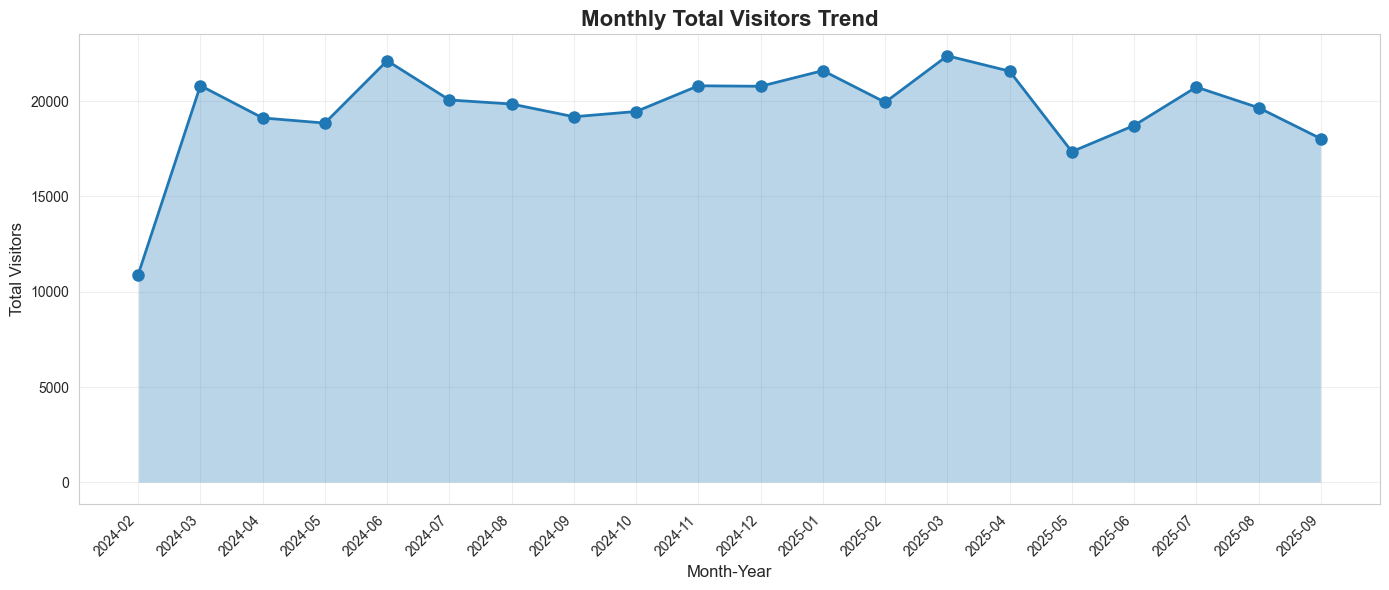

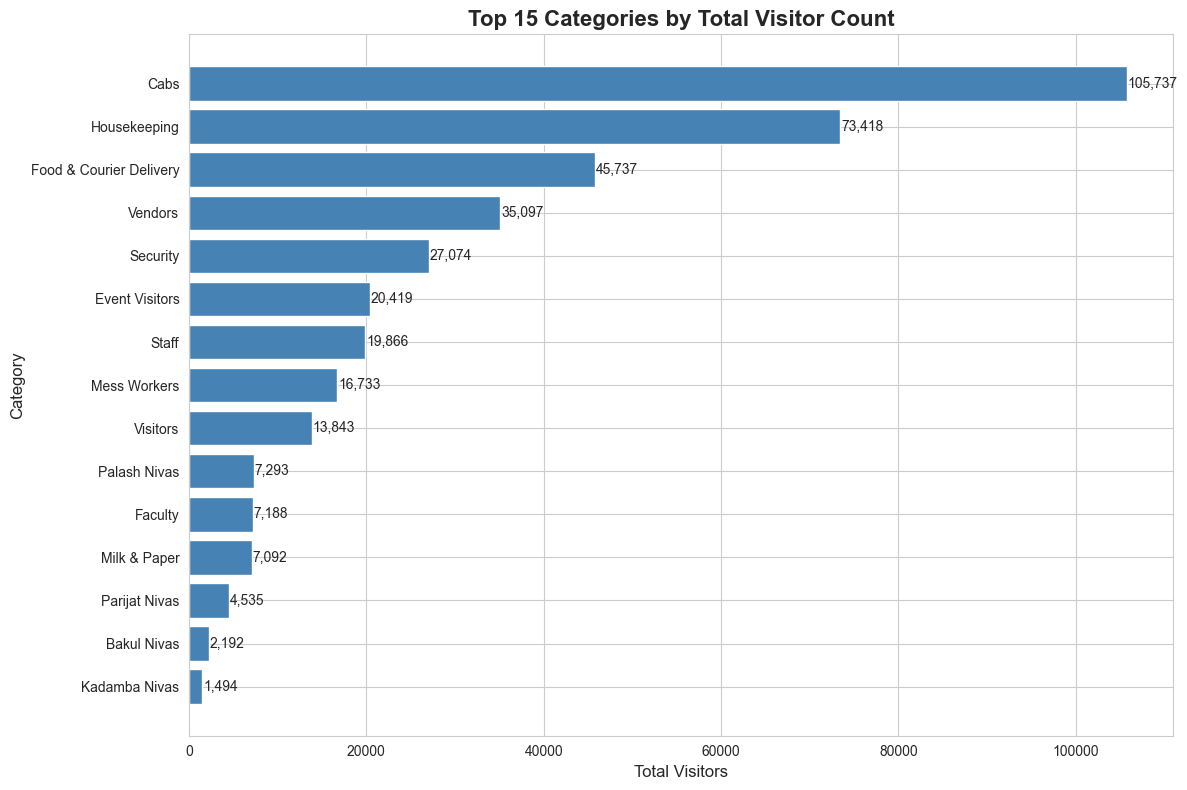

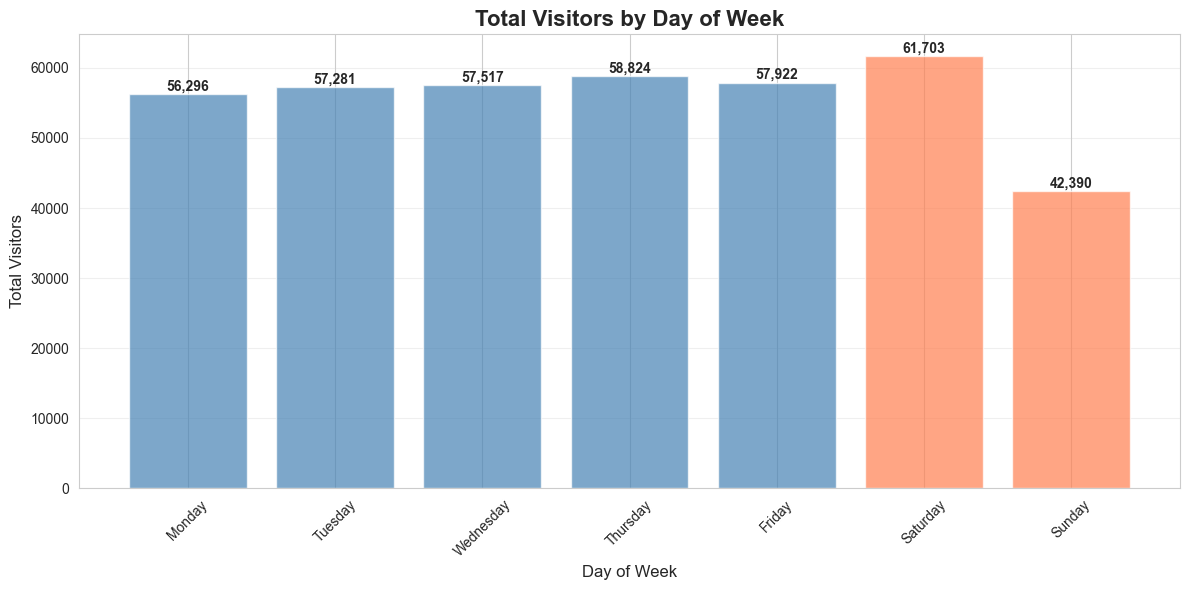

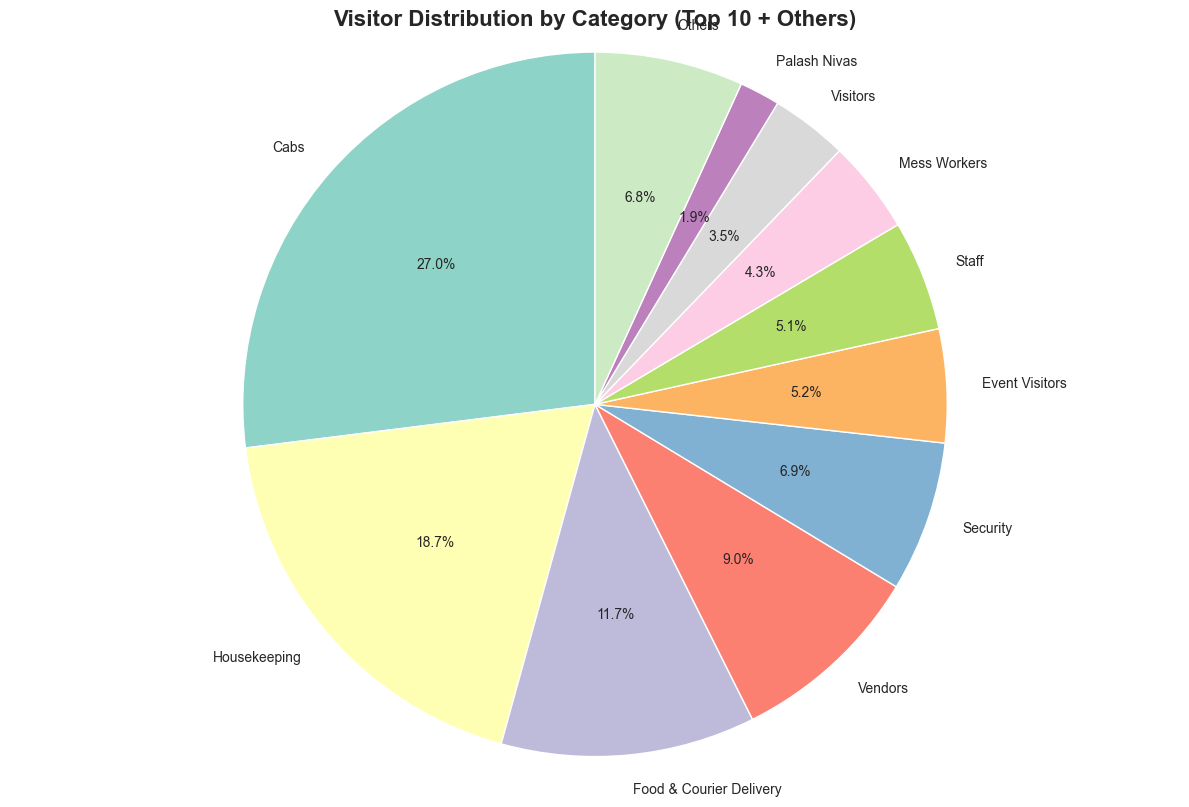

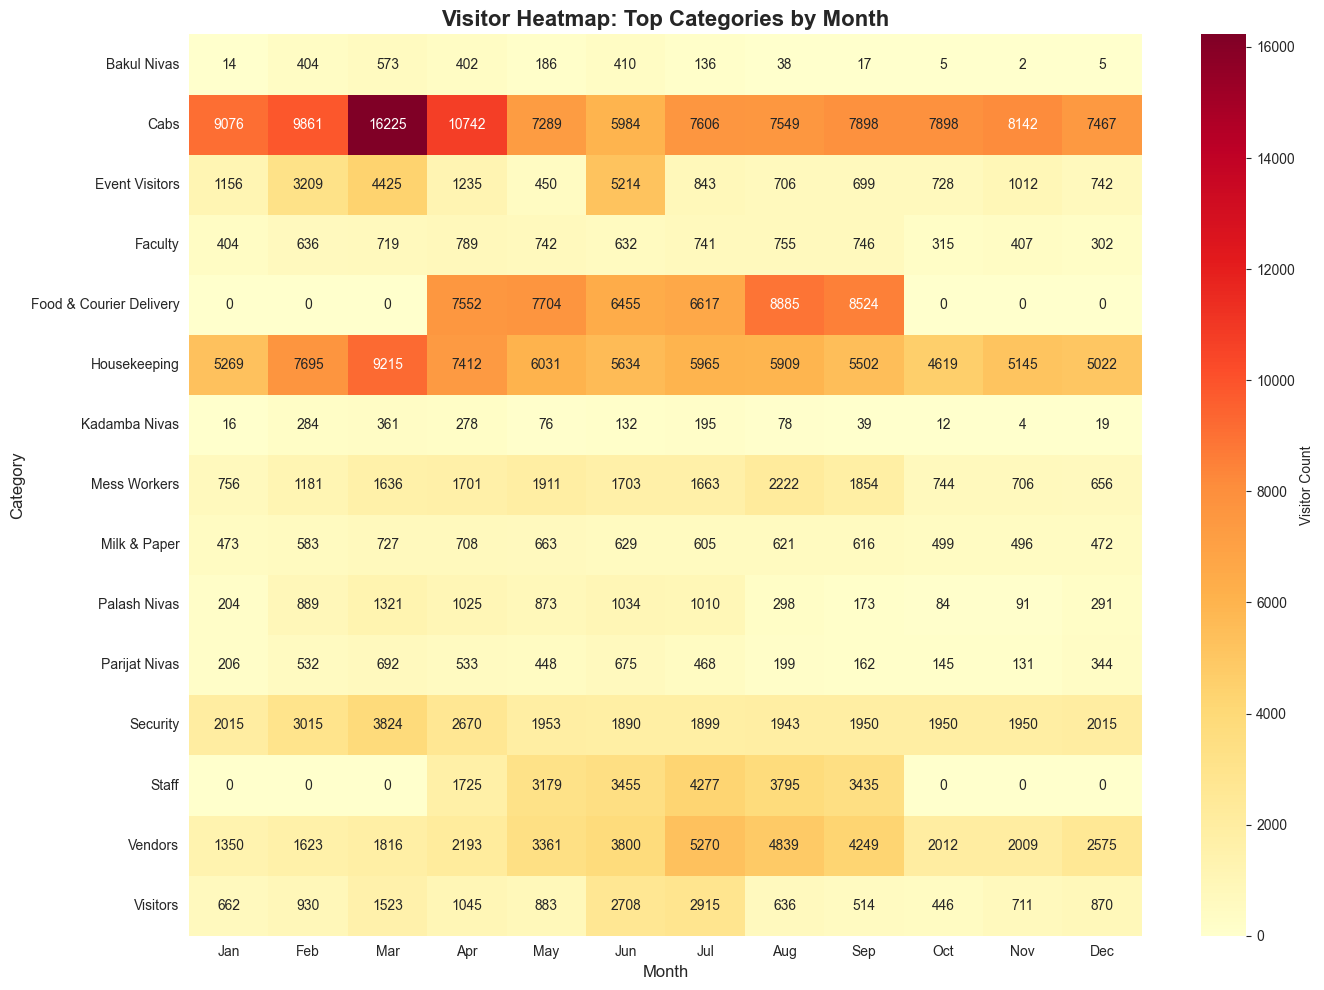


✅ Visualizations saved to result/ folder:
   ✓ viz_01_monthly_trend.png
   ✓ viz_02_top_categories.png
   ✓ viz_03_day_of_week.png
   ✓ viz_04_category_distribution.png
   ✓ viz_05_category_month_heatmap.png


In [9]:
# ========================================
# SECTION 9: VISUALIZATION SAMPLES
# ========================================

print("📊 GENERATING KEY VISUALIZATIONS")
print("="*60)

# 9.1 Monthly trends line chart
plt.figure(figsize=(14, 6))
monthly_plot = monthly_totals.sort_values('First_Date')
plt.plot(monthly_plot['Month_Year_Str'], monthly_plot['Total_Visitors'], marker='o', linewidth=2, markersize=8)
plt.fill_between(range(len(monthly_plot)), monthly_plot['Total_Visitors'], alpha=0.3)
plt.title('Monthly Total Visitors Trend', fontsize=16, fontweight='bold')
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Visitors', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('result/viz_01_monthly_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# 9.2 Top 15 categories bar chart
plt.figure(figsize=(12, 8))
top_15 = category_totals.head(15).sort_values('Total_Count')
plt.barh(top_15['Category'], top_15['Total_Count'], color='steelblue')
plt.title('Top 15 Categories by Total Visitor Count', fontsize=16, fontweight='bold')
plt.xlabel('Total Visitors', fontsize=12)
plt.ylabel('Category', fontsize=12)
for i, v in enumerate(top_15['Total_Count']):
    plt.text(v + 100, i, f'{v:,}', va='center')
plt.tight_layout()
plt.savefig('result/viz_02_top_categories.png', dpi=300, bbox_inches='tight')
plt.show()

# 9.3 Day of week patterns
plt.figure(figsize=(12, 6))
dow_sorted = dow_analysis.sort_values('DayOfWeek_Num')
colors = ['steelblue' if not day in ['Saturday', 'Sunday'] else 'coral' for day in dow_sorted['DayOfWeek']]
plt.bar(dow_sorted['DayOfWeek'], dow_sorted['Total_Visitors'], color=colors, alpha=0.7)
plt.title('Total Visitors by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Visitors', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(dow_sorted['Total_Visitors']):
    plt.text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('result/viz_03_day_of_week.png', dpi=300, bbox_inches='tight')
plt.show()

# 9.4 Category distribution pie chart
plt.figure(figsize=(12, 8))
top_10_pie = category_totals.head(10)
others_sum = category_totals.iloc[10:]['Total_Count'].sum()
pie_data = pd.concat([
    top_10_pie[['Category', 'Total_Count']],
    pd.DataFrame([{'Category': 'Others', 'Total_Count': others_sum}])
])
colors_pie = plt.cm.Set3(range(len(pie_data)))
plt.pie(pie_data['Total_Count'], labels=pie_data['Category'], autopct='%1.1f%%', startangle=90, colors=colors_pie)
plt.title('Visitor Distribution by Category (Top 10 + Others)', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.savefig('result/viz_04_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 9.5 Heatmap: Category vs Month
plt.figure(figsize=(14, 10))
top_cats_heatmap = category_totals.head(15)['Category'].tolist()
heatmap_data = df[df['Category'].isin(top_cats_heatmap)].groupby(['Category', 'Month_Name', 'Month'])['Count'].sum().reset_index()
heatmap_pivot = heatmap_data.pivot_table(index='Category', columns='Month_Name', values='Count', fill_value=0)
# Reorder months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_pivot = heatmap_pivot.reindex(columns=[m for m in month_order if m in heatmap_pivot.columns])
sns.heatmap(heatmap_pivot, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Visitor Count'})
plt.title('Visitor Heatmap: Top Categories by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.savefig('result/viz_05_category_month_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualizations saved to result/ folder:")
print("   ✓ viz_01_monthly_trend.png")
print("   ✓ viz_02_top_categories.png")
print("   ✓ viz_03_day_of_week.png")
print("   ✓ viz_04_category_distribution.png")
print("   ✓ viz_05_category_month_heatmap.png")

In [10]:
# ========================================
# SECTION 10: COMPREHENSIVE SUMMARY REPORT
# ========================================

print("📋 GENERATING COMPREHENSIVE SUMMARY REPORT")
print("="*60)

# Create a comprehensive summary
summary_report = {
    'Report_Generated': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Data_Period_Start': df['Date'].min().strftime('%d-%b-%Y'),
    'Data_Period_End': df['Date'].max().strftime('%d-%b-%Y'),
    'Total_Days': (df['Date'].max() - df['Date'].min()).days + 1,
    'Days_With_Data': df['Date'].nunique(),
    'Data_Completeness_Pct': (df['Date'].nunique() / ((df['Date'].max() - df['Date'].min()).days + 1)) * 100,
    'Total_Records': len(df),
    'Total_Visitors': df['Count'].sum(),
    'Unique_Categories': df['Category'].nunique(),
    'Avg_Daily_Visitors': df.groupby('Date')['Count'].sum().mean(),
    'Max_Daily_Visitors': df.groupby('Date')['Count'].sum().max(),
    'Min_Daily_Visitors': df.groupby('Date')['Count'].sum().min(),
    'StdDev_Daily_Visitors': df.groupby('Date')['Count'].sum().std(),
    'Top_Category': category_totals.iloc[0]['Category'],
    'Top_Category_Count': category_totals.iloc[0]['Total_Count'],
    'Top_Category_Percentage': category_totals.iloc[0]['Percentage'],
    'Busiest_Day_Of_Week': dow_analysis.iloc[dow_analysis['Total_Visitors'].idxmax()]['DayOfWeek'],
    'Quietest_Day_Of_Week': dow_analysis.iloc[dow_analysis['Total_Visitors'].idxmin()]['DayOfWeek'],
    'Weekend_Avg': weekend_comparison[weekend_comparison['IsWeekend']=='Weekend']['Avg_Per_Day'].values[0],
    'Weekday_Avg': weekend_comparison[weekend_comparison['IsWeekend']=='Weekday']['Avg_Per_Day'].values[0],
    'Anomalies_Detected': len(anomalies),
    'Major_Events_Detected': len(major_events),
    'HHI_Concentration': hhi,
    'Files_Generated': 39 + 5  # CSV files + visualizations
}

summary_df = pd.DataFrame([summary_report])
summary_df.to_csv('result/00_SUMMARY_REPORT.csv', index=False)

# Create a detailed metrics inventory
metrics_inventory = pd.DataFrame({
    'File_Name': [
        '00_SUMMARY_REPORT.csv',
        '01_cleaned_data.csv',
        '02_daily_footfall.csv',
        '03_weekly_footfall.csv',
        '04_monthly_category_footfall.csv',
        '05_monthly_totals.csv',
        '06_day_of_week_analysis.csv',
        '07_weekend_vs_weekday.csv',
        '08_quarterly_footfall.csv',
        '09_yearly_comparison.csv',
        '10_category_totals.csv',
        '11_category_growth.csv',
        '12_category_frequency.csv',
        '13_category_peaks.csv',
        '14_category_seasonal.csv',
        '15_top_20_categories.csv',
        '16_daily_operations.csv',
        '17_peak_days.csv',
        '18_low_traffic_days.csv',
        '19_operational_stats.csv',
        '20_traffic_distribution.csv',
        '21_monthly_operations.csv',
        '22_food_delivery_daily.csv',
        '23_food_delivery_summary.csv',
        '24_vendor_summary.csv',
        '25_security_summary.csv',
        '26_cab_summary.csv',
        '27_visitor_summary.csv',
        '28_nivas_summary.csv',
        '29_housekeeping_summary.csv',
        '30_staff_summary.csv',
        '31_major_events.csv',
        '32_correlation_analysis.csv',
        '33_correlation_matrix.csv',
        '34_anomalies.csv',
        '35_trend_decomposition.csv',
        '36_forecast_7days.csv',
        '37_volatility_summary.csv',
        '38_category_profiles.csv',
        '39_concentration_metrics.csv',
        'viz_01_monthly_trend.png',
        'viz_02_top_categories.png',
        'viz_03_day_of_week.png',
        'viz_04_category_distribution.png',
        'viz_05_category_month_heatmap.png'
    ],
    'Category': [
        'Summary',
        'Raw Data',
        'Temporal', 'Temporal', 'Temporal', 'Temporal', 'Temporal', 'Temporal', 'Temporal', 'Temporal',
        'Category', 'Category', 'Category', 'Category', 'Category', 'Category',
        'Operations', 'Operations', 'Operations', 'Operations', 'Operations', 'Operations',
        'Stakeholders', 'Stakeholders', 'Stakeholders', 'Stakeholders', 'Stakeholders', 'Stakeholders', 'Stakeholders', 'Stakeholders', 'Stakeholders', 'Stakeholders',
        'Advanced', 'Advanced', 'Advanced', 'Advanced', 'Advanced', 'Advanced', 'Advanced', 'Advanced',
        'Visualization', 'Visualization', 'Visualization', 'Visualization', 'Visualization'
    ],
    'Description': [
        'Overall summary of all metrics',
        'Cleaned and standardized raw data',
        'Daily visitor totals', 'Weekly aggregation', 'Monthly category breakdown', 'Monthly totals with MoM growth',
        'Patterns by day of week', 'Weekend vs weekday comparison', 'Quarterly aggregation', 'Year-over-year comparison',
        'Category totals and statistics', 'Growth trends (first vs last 3 months)', 'Frequency and regularity',
        'Peak counts per category', 'Seasonal patterns by month', 'Top 20 categories detailed',
        'Daily operational metrics', 'Top 10 busiest days', 'Top 10 quietest days', 'Key operational statistics',
        'Traffic level distribution', 'Monthly operational summary',
        'Daily food delivery counts', 'Food delivery summary', 'Vendor visit summary', 'Security staff tracking',
        'Cab entry summary', 'Visitor pattern summary', 'Residence hall traffic', 'Housekeeping workload',
        'Staff attendance patterns', 'Major event identification',
        'Strong correlations between categories', 'Full correlation matrix', 'Anomaly detection results',
        'Trend and seasonality', '7-day forecast', 'Volatility metrics', 'Category behavior clusters',
        'Market concentration (HHI)',
        'Monthly trend visualization', 'Top categories bar chart', 'Day of week patterns',
        'Category distribution pie chart', 'Category-Month heatmap'
    ]
})
metrics_inventory.to_csv('result/METRICS_INVENTORY.csv', index=False)

print("\n" + "="*60)
print("✅ ANALYSIS COMPLETE!")
print("="*60)
print(f"\n📊 Summary Statistics:")
print(f"   - Total Visitors: {summary_report['Total_Visitors']:,}")
print(f"   - Date Range: {summary_report['Data_Period_Start']} to {summary_report['Data_Period_End']}")
print(f"   - Days Analyzed: {summary_report['Days_With_Data']} / {summary_report['Total_Days']}")
print(f"   - Data Completeness: {summary_report['Data_Completeness_Pct']:.1f}%")
print(f"   - Unique Categories: {summary_report['Unique_Categories']}")
print(f"   - Avg Daily Visitors: {summary_report['Avg_Daily_Visitors']:.0f}")

print(f"\n📁 Files Generated: {summary_report['Files_Generated']}")
print(f"   - CSV Reports: 40")
print(f"   - Visualizations: 5")

print(f"\n🎯 Top Insights:")
print(f"   - Top Category: {summary_report['Top_Category']} ({summary_report['Top_Category_Percentage']:.1f}%)")
print(f"   - Busiest Day: {summary_report['Busiest_Day_Of_Week']}")
print(f"   - Weekend vs Weekday: {summary_report['Weekend_Avg']:.0f} vs {summary_report['Weekday_Avg']:.0f}")
print(f"   - Anomalies: {summary_report['Anomalies_Detected']} detected")
print(f"   - Major Events: {summary_report['Major_Events_Detected']} identified")

print(f"\n📂 All results saved to: result/")
print(f"   Use these files to build your Streamlit dashboard!")

print("\n" + "="*60)

summary_df.T

📋 GENERATING COMPREHENSIVE SUMMARY REPORT

✅ ANALYSIS COMPLETE!

📊 Summary Statistics:
   - Total Visitors: 391,933
   - Date Range: 10-Feb-2024 to 25-Sep-2025
   - Days Analyzed: 587 / 594
   - Data Completeness: 98.8%
   - Unique Categories: 24
   - Avg Daily Visitors: 668

📁 Files Generated: 44
   - CSV Reports: 40
   - Visualizations: 5

🎯 Top Insights:
   - Top Category: Cabs (27.0%)
   - Busiest Day: Wednesday
   - Weekend vs Weekday: 44 vs 48
   - Anomalies: 15 detected
   - Major Events: 19 identified

📂 All results saved to: result/
   Use these files to build your Streamlit dashboard!



,0
Report_Generated,2025-11-16 23:02:37
Data_Period_Start,10-Feb-2024
Data_Period_End,25-Sep-2025
Total_Days,594
Days_With_Data,587
Data_Completeness_Pct,98.821549
Total_Records,8347
Total_Visitors,391933
Unique_Categories,24
Avg_Daily_Visitors,667.688245


In [11]:
# ========================================
# QUICK REFERENCE: FILES GENERATED
# ========================================

print("📋 QUICK REFERENCE GUIDE")
print("="*60)
print("\n🗂️  ALL FILES IN result/ FOLDER:\n")

categories = {
    '📊 SUMMARY & RAW DATA': [
        '00_SUMMARY_REPORT.csv - Overall summary of all metrics',
        '01_cleaned_data.csv - Complete cleaned dataset',
        'METRICS_INVENTORY.csv - Guide to all files'
    ],
    '📅 TEMPORAL ANALYSIS (9 files)': [
        '02_daily_footfall.csv - Daily visitor counts',
        '03_weekly_footfall.csv - Weekly aggregation',
        '04_monthly_category_footfall.csv - Monthly by category',
        '05_monthly_totals.csv - Monthly totals with MoM growth',
        '06_day_of_week_analysis.csv - Day of week patterns',
        '07_weekend_vs_weekday.csv - Weekend comparison',
        '08_quarterly_footfall.csv - Quarterly trends',
        '09_yearly_comparison.csv - Year-over-year'
    ],
    '📂 CATEGORY ANALYSIS (6 files)': [
        '10_category_totals.csv - All category statistics',
        '11_category_growth.csv - Growth trends',
        '12_category_frequency.csv - Frequency patterns',
        '13_category_peaks.csv - Peak days per category',
        '14_category_seasonal.csv - Seasonal patterns',
        '15_top_20_categories.csv - Top 20 detailed'
    ],
    '⚙️  OPERATIONS (6 files)': [
        '16_daily_operations.csv - Daily operational metrics',
        '17_peak_days.csv - Top 10 busiest days',
        '18_low_traffic_days.csv - Top 10 quietest days',
        '19_operational_stats.csv - Key statistics',
        '20_traffic_distribution.csv - Traffic levels',
        '21_monthly_operations.csv - Monthly ops summary'
    ],
    '👥 STAKEHOLDERS (10 files)': [
        '22_food_delivery_daily.csv - Food delivery tracking',
        '23_food_delivery_summary.csv - Food delivery stats',
        '24_vendor_summary.csv - Vendor patterns',
        '25_security_summary.csv - Security staff',
        '26_cab_summary.csv - Cab/vehicle entries',
        '27_visitor_summary.csv - Visitor patterns',
        '28_nivas_summary.csv - Residence halls',
        '29_housekeeping_summary.csv - Housekeeping workload',
        '30_staff_summary.csv - Staff attendance',
        '31_major_events.csv - Major event detection'
    ],
    '🔬 ADVANCED ANALYTICS (8 files)': [
        '32_correlation_analysis.csv - Strong correlations',
        '33_correlation_matrix.csv - Full matrix',
        '34_anomalies.csv - Anomaly detection',
        '35_trend_decomposition.csv - Trends & seasonality',
        '36_forecast_7days.csv - 7-day forecast',
        '37_volatility_summary.csv - Volatility metrics',
        '38_category_profiles.csv - Category clustering',
        '39_concentration_metrics.csv - Market concentration'
    ],
    '📊 VISUALIZATIONS (5 files)': [
        'viz_01_monthly_trend.png - Monthly trend chart',
        'viz_02_top_categories.png - Top categories bar',
        'viz_03_day_of_week.png - Day of week patterns',
        'viz_04_category_distribution.png - Pie chart',
        'viz_05_category_month_heatmap.png - Heatmap'
    ]
}

for category, files in categories.items():
    print(f"\n{category}")
    print("-" * 60)
    for file in files:
        print(f"   • {file}")

print("\n" + "="*60)
print("✅ Total: 45 files ready for Streamlit dashboard")
print("="*60)

# List actual files in result directory
import os
result_files = sorted([f for f in os.listdir('result') if not f.startswith('.')])
print(f"\n✓ Verified: {len(result_files)} files in result/ folder")
print(f"\n📂 Ready for your Streamlit dashboard!")

📋 QUICK REFERENCE GUIDE

🗂️  ALL FILES IN result/ FOLDER:


📊 SUMMARY & RAW DATA
------------------------------------------------------------
   • 00_SUMMARY_REPORT.csv - Overall summary of all metrics
   • 01_cleaned_data.csv - Complete cleaned dataset
   • METRICS_INVENTORY.csv - Guide to all files

📅 TEMPORAL ANALYSIS (9 files)
------------------------------------------------------------
   • 02_daily_footfall.csv - Daily visitor counts
   • 03_weekly_footfall.csv - Weekly aggregation
   • 04_monthly_category_footfall.csv - Monthly by category
   • 05_monthly_totals.csv - Monthly totals with MoM growth
   • 06_day_of_week_analysis.csv - Day of week patterns
   • 07_weekend_vs_weekday.csv - Weekend comparison
   • 08_quarterly_footfall.csv - Quarterly trends
   • 09_yearly_comparison.csv - Year-over-year

📂 CATEGORY ANALYSIS (6 files)
------------------------------------------------------------
   • 10_category_totals.csv - All category statistics
   • 11_category_growth.csv - Growth